# nuImages devkit tutorial

Welcome to the nuImages tutorial.
This demo assumes the database itself is available at `/data/sets/nuimages`, and loads a mini version of the dataset.

## A Gentle Introduction to nuImages

In this part of the tutorial, let us go through a top-down introduction of our database. Our dataset is structured as a relational database with tables, tokens and foreign keys. The tables are the following:

1. `log` - Log from which the sample was extracted.
2. `sample` - An annotated camera image with an associated timestamp and past and future images and pointclouds.
3. `sample_data` - An image or pointcloud associated with a sample.
4. `ego_pose` - The vehicle ego pose and timestamp associated with a sample_data.
5. `sensor` - General information about a sensor, e.g. `CAM_BACK_LEFT`.
6. `calibrated_sensor` - Calibration information of a sensor in a log.
7. `category` - Taxonomy of object and surface categories (e.g. `vehicle.car`, `flat.driveable_surface`). 
8. `attribute` - Property of an object that can change while the category remains the same.
9. `object_ann` - Bounding box and mask annotation of an object (e.g. car, adult).
10. `surface_ann` - Mask annotation of a surface (e.g. `flat.driveable surface` and `vehicle.ego`).

The database schema is visualized below. For more information see the [schema page](https://github.com/nutonomy/nuscenes-devkit/blob/master/docs/schema_nuimages.md).
![](https://www.nuscenes.org/public/images/nuimages-schema.svg)

## Google Colab (optional)

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuimages_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left">
</a>
<br>
    
If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, manually set up everything.

In [ ]:
# !mkdir -p /data/sets/nuimages  # Make the directory to store the nuImages dataset in.

# !wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

# !tar -xf nuimages-v1.0-mini.tgz -C /data/sets/nuimages  # Uncompress the nuImages mini split.

# !pip install nuscenes-devkit &> /dev/null  # Install nuImages.

## Initialization
To initialize the dataset class, we run the code below. We can change the dataroot parameter if the dataset is installed in a different folder. We can also omit it to use the default setup. These will be useful further below.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from nuimages import NuImages

nuim = NuImages(dataroot='/data/nperi/nuImages/', version='v1.0-val', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-val...
Done loading in 0.000 seconds (lazy=True).


## Tables

As described above, the NuImages class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [2]:
nuim.category[0]

Loaded 25 category(s) in 0.011s,


{'token': '63a94dfa99bb47529567cd90d3b58384',
 'name': 'animal',
 'description': 'All animals, e.g. cats, rats, dogs, deer, birds.'}

To see the list of all tables, simply refer to the `table_names` variable:

In [3]:
nuim.table_names

['attribute',
 'calibrated_sensor',
 'category',
 'ego_pose',
 'log',
 'object_ann',
 'sample',
 'sample_data',
 'sensor',
 'surface_ann']

### Indexing

Since all tables are lists of dictionaries, we can use standard Python operations on them. A very common operation is to retrieve a particular record by its token. Since this operation takes linear time, we precompute an index that helps to access a record in constant time.

Let us select the first image in this dataset version and split:

In [4]:
sample_idx = 139
sample = nuim.sample[sample_idx]
sample

Loaded 16445 sample(s) in 0.085s,


{'token': '02338340441b446c807e06bc1409501a',
 'timestamp': 1537199961854671,
 'log_token': '54ad9fdba3204dc1a765d17da14e74ef',
 'key_camera_token': 'bac8e33f708c48f1b553971b7b2158f8'}

We can also get the sample record from a sample token:

In [5]:
sample = nuim.get('sample', sample['token'])
sample

{'token': '02338340441b446c807e06bc1409501a',
 'timestamp': 1537199961854671,
 'log_token': '54ad9fdba3204dc1a765d17da14e74ef',
 'key_camera_token': 'bac8e33f708c48f1b553971b7b2158f8'}

What this does is actually to lookup the index. We see that this is the same index as we used in the first place.

In [6]:
sample_idx_check = nuim.getind('sample', sample['token'])
assert sample_idx == sample_idx_check

From the sample, we can directly access the corresponding keyframe sample data. This will be useful further below.

In [7]:
key_camera_token = sample['key_camera_token']
print(key_camera_token)

bac8e33f708c48f1b553971b7b2158f8


In [21]:
sample = nuim.get('sample_data', sample['key_camera_token'])

In [22]:
sample

{'token': 'bac8e33f708c48f1b553971b7b2158f8',
 'sample_token': '02338340441b446c807e06bc1409501a',
 'ego_pose_token': 'ec5fe605be394361ae904a936f063c25',
 'calibrated_sensor_token': 'fb8b22d4f9f5570dbe2e589f31cd6678',
 'filename': 'samples/CAM_FRONT_LEFT/n006-2018-09-17-11-57-46-0400__CAM_FRONT_LEFT__1537199961854671.jpg',
 'fileformat': 'jpg',
 'width': 1600,
 'height': 900,
 'timestamp': 1537199961854671,
 'is_key_frame': True,
 'prev': 'd70a12b097b04886b142f718694fc2a9',
 'next': '868d01efbc1049ff835c449d1a1a65cd'}

### Lazy loading

Initializing the NuImages instance above was very fast, as we did not actually load the tables. Rather, the class implements lazy loading that overwrites the internal `__getattr__()` function to load a table if it is not already stored in memory. The moment we accessed `category`, we could see the table being loaded from disk. To disable such notifications, just set `verbose=False` when initializing the NuImages object. Furthermore lazy loading can be disabled with `lazy=False`.

## Rendering

To render an image we use the `render_image()` function. We can see the boxes and masks for each object category, as well as the surface masks for ego vehicle and driveable surface. We use the following colors:
- vehicles: orange
- bicycles and motorcycles: red
- pedestrians: blue
- cones and barriers: gray
- driveable surface: teal / green

At the top left corner of each box, we see the name of the object category (if `with_category=True`). We can also set `with_attributes=True` to print the attributes of each object (note that we can only set `with_attributes=True` to print the attributes of each object when `with_category=True`). In addition, we can specify if we want to see surfaces and objects, or only surfaces, or only objects, or neither by setting `with_annotations` to `all`, `surfaces`, `objects` and `none` respectively.

Let us make the image bigger for better visibility by setting `render_scale=2`. We can also change the line width of the boxes using `box_line_width`. By setting it to -1, the line width adapts to the `render_scale`. Finally, we can render the image to disk using `out_path`.

Loaded 213185 sample_data(s) in 1.031s,
Loaded 17995 surface_ann(s) in 0.770s,
Loaded 136074 object_ann(s) in 1.133s,
Loaded 12 attribute(s) in 0.007s,


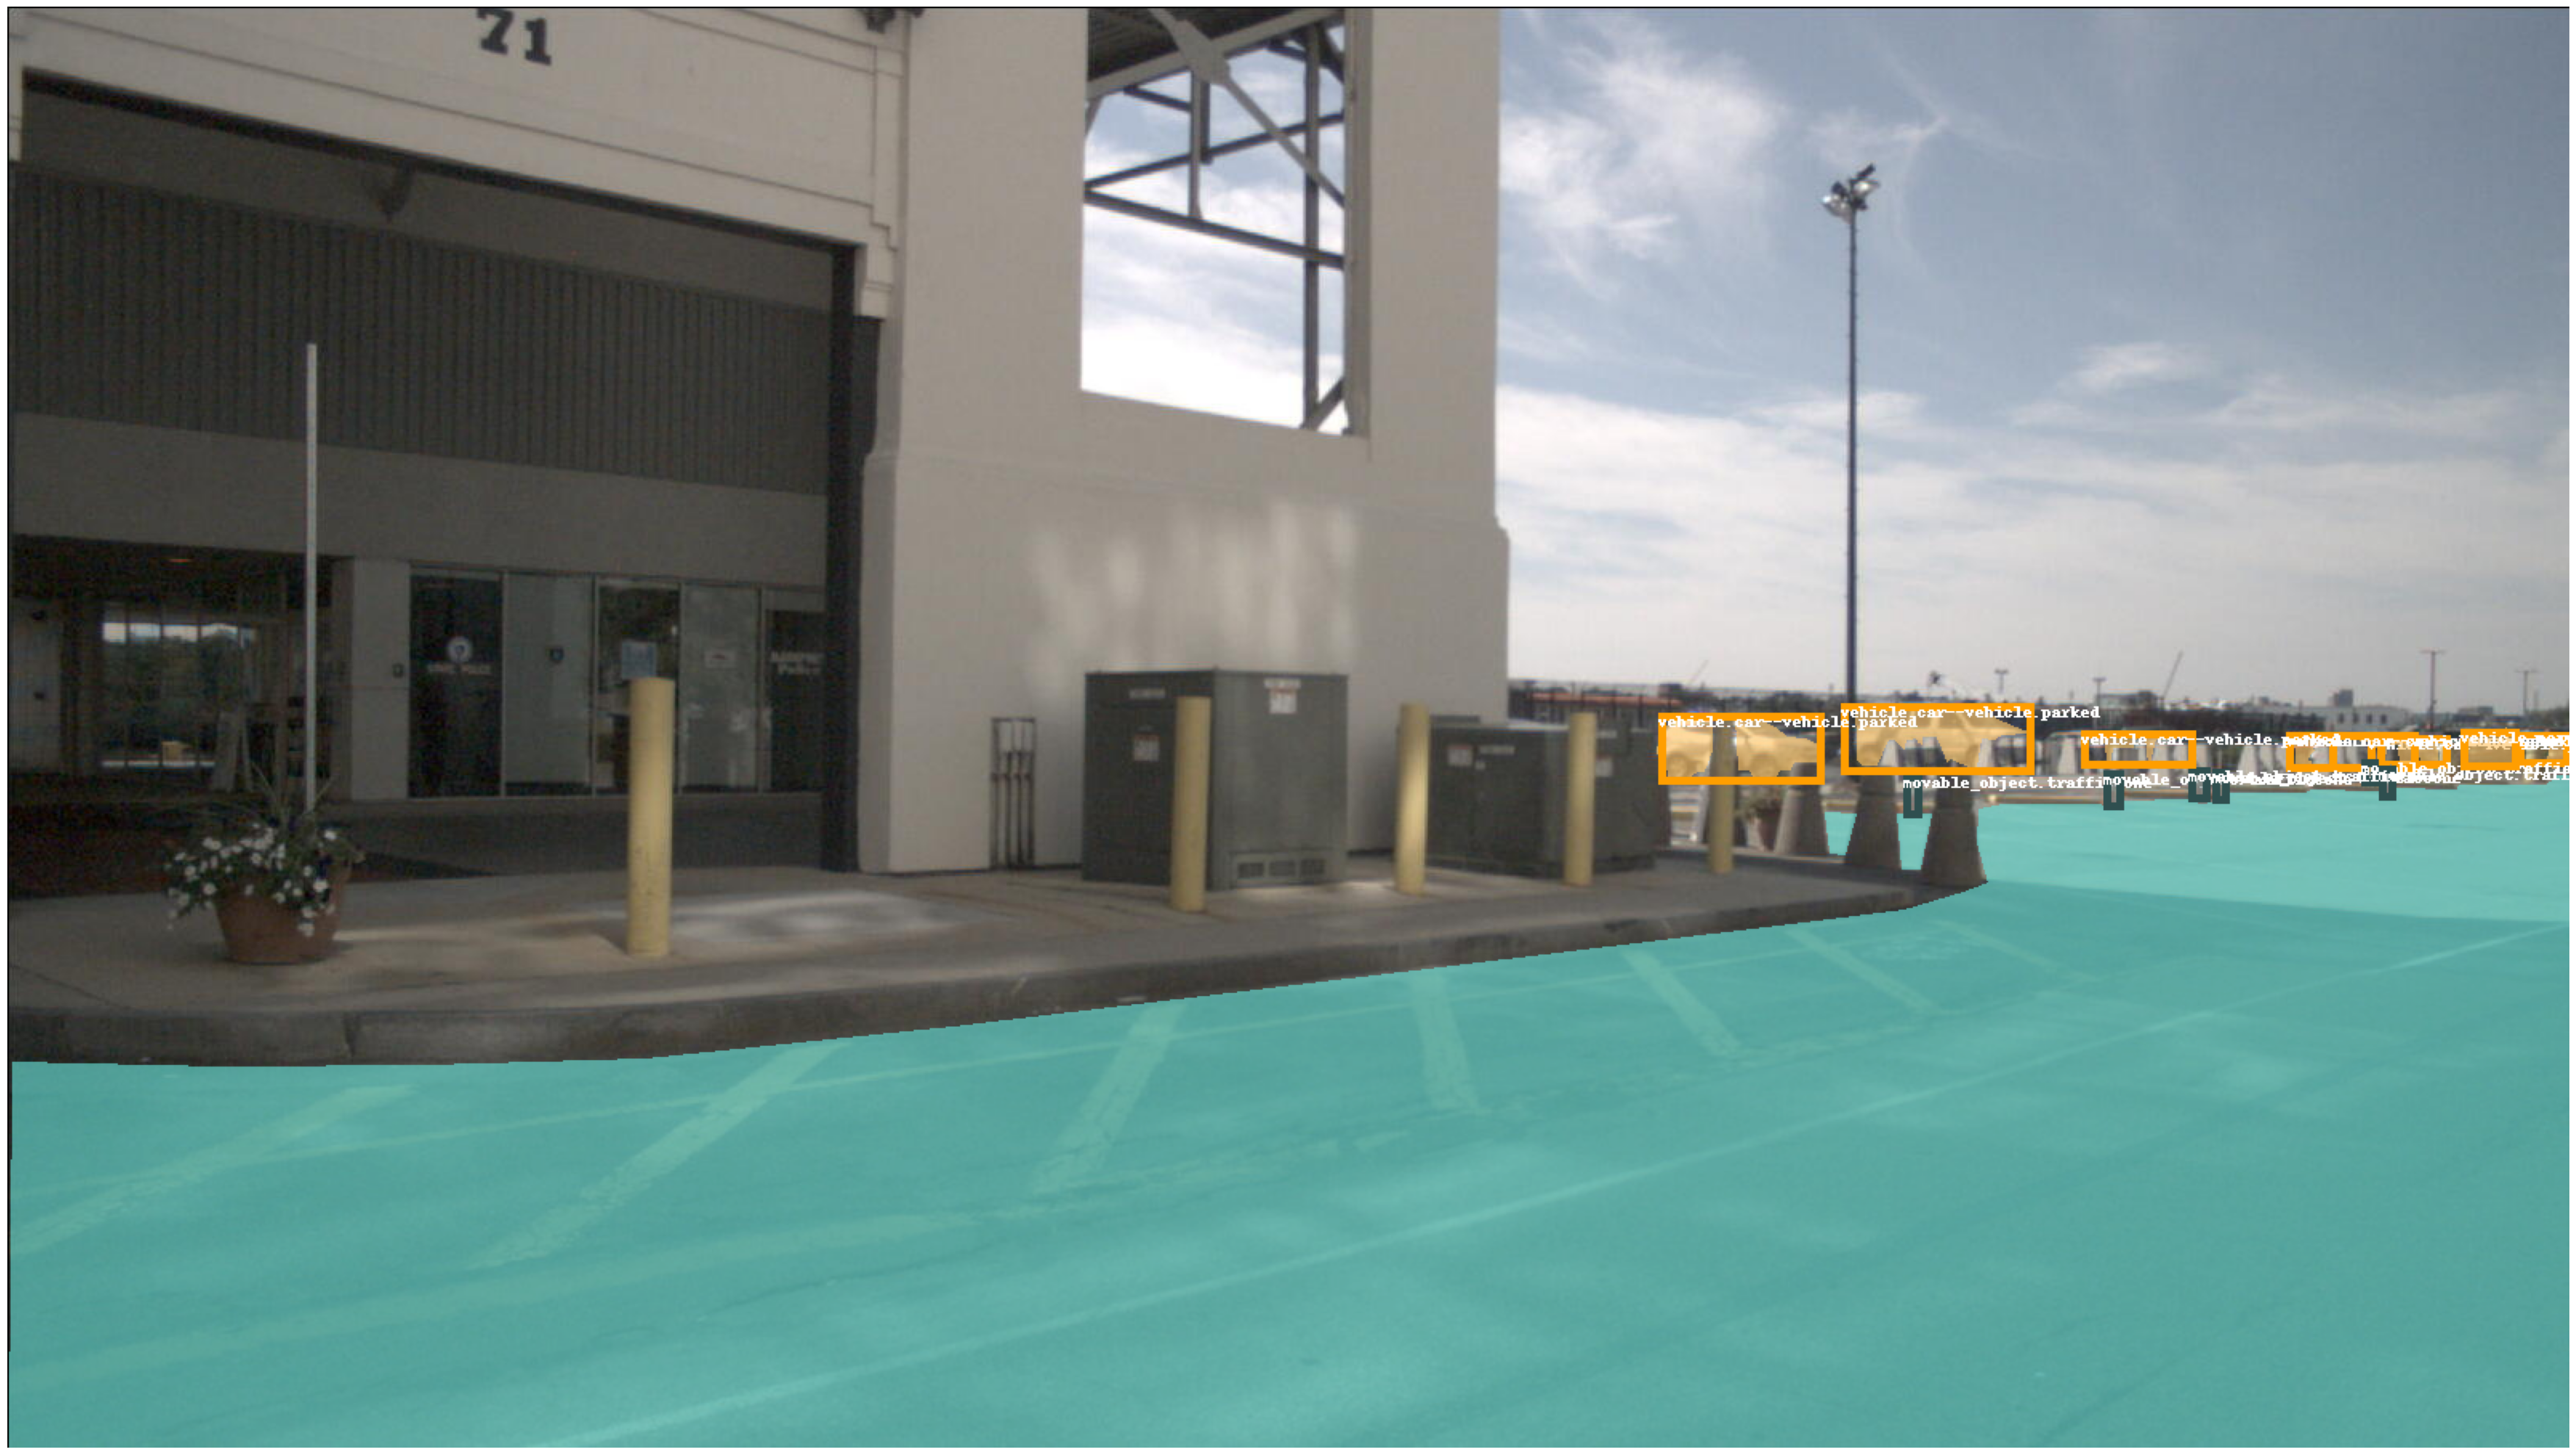

In [8]:
nuim.render_image(key_camera_token, annotation_type='all',
                  with_category=True, with_attributes=True, box_line_width=-1, render_scale=5)

In [9]:
# nuim.categories()

Let us find out which annotations are in that image.

In [10]:
sample_data = nuim.get('sample_data', sample['key_camera_token'])
sd_token = sample_data['token']


In [11]:
object_anns = [o for o in nuim.object_ann if o['sample_data_token'] == sd_token]

In [12]:
category_names = [nuim.get('category', o['category_token']) for o in object_anns]

In [13]:
nuim.list_categories()


Object_anns Surface_anns Name                     Description                                     
      47279            0 vehicle.car              Vehicle designed primarily for personal use, e.g
      28721            0 human.pedestrian.adult   Adult subcategory.                              
      18587            0 movable_object.trafficco All types of traffic cone.                      
      18433            0 movable_object.barrier   Temporary road barrier placed in the scene in or
       6858            0 vehicle.truck            Vehicles primarily designed to haul cargo includ
       3352            0 vehicle.bicycle          Human or electric powered 2-wheeled vehicle desi
       3117            0 human.pedestrian.constru Construction worker                             
       3097            0 vehicle.motorcycle       Gasoline or electric powered 2-wheeled vehicle d
       1823            0 vehicle.bus.rigid        Rigid bus subcategory.                          
       13

In [14]:
all_cat_names = [x['name'] for x in nuim.__load_table__('category')]

Loaded 25 category(s) in 0.000s,


In [15]:
all_cat_names

['animal',
 'flat.driveable_surface',
 'human.pedestrian.adult',
 'human.pedestrian.child',
 'human.pedestrian.construction_worker',
 'human.pedestrian.personal_mobility',
 'human.pedestrian.police_officer',
 'human.pedestrian.stroller',
 'human.pedestrian.wheelchair',
 'movable_object.barrier',
 'movable_object.debris',
 'movable_object.pushable_pullable',
 'movable_object.trafficcone',
 'static_object.bicycle_rack',
 'vehicle.bicycle',
 'vehicle.bus.bendy',
 'vehicle.bus.rigid',
 'vehicle.car',
 'vehicle.construction',
 'vehicle.ego',
 'vehicle.emergency.ambulance',
 'vehicle.emergency.police',
 'vehicle.motorcycle',
 'vehicle.trailer',
 'vehicle.truck']

In [16]:
class_mapping = {'human.pedestrian.adult': 8, 'human.pedestrian.child': 9, 'human.pedestrian.construction_worker': 11, 'human.pedestrian.personal_mobility': 12, 'human.pedestrian.police_officer': 10,
                 'human.pedestrian.stroller': 14, 'human.pedestrian.wheelchair': 13, 'movable_object.barrier': 16, 'movable_object.debris': 18, 'movable_object.pushable_pullable': 15, 'movable_object.trafficcone': 17,
                 'static_object.bicycle_rack': 7, 'vehicle.bicycle': 7, 'vehicle.bus.bendy': 3, 'vehicle.bus.rigid': 3, 'vehicle.car': 0, 'vehicle.construction': 2, 'vehicle.emergency.ambulance': 5, 
                 'vehicle.emergency.police': 5, 'vehicle.motorcycle': 6, 'vehicle.trailer': 4, 'vehicle.truck': 1 }

In [17]:
object_tokens, surface_tokens = nuim.list_anns(sample['token'])

Printing object annotations:
1c067b0ccbcf455e92864d470676a51a movable_object.trafficcone []
3b7868327d9f4fe6a20f009376c399ad vehicle.car ['vehicle.parked']
3d4cdce4906f42db9a9f29d13aa0e3c9 vehicle.car ['vehicle.parked']
4666c937271a4469b5422dc4cd08924f movable_object.trafficcone []
4c40a9b96ee4437a94341671300e9274 vehicle.car ['vehicle.parked']
52cf831cb40849f190669ce0a3f31ef4 vehicle.car ['vehicle.parked']
666486c9a8584dbfa81a7a82ea8138dc vehicle.car ['vehicle.parked']
711f30eca93249a48c44f254802944f6 movable_object.trafficcone []
842ff6cdf1fe4f6d8a41c014749c86e9 movable_object.trafficcone []
875287d82f6b4adaa8191667047e9018 movable_object.trafficcone []
8cf632e4156d47f0bc933f2364333d35 movable_object.trafficcone []
93a059459acf42a7a64475e74cc6e3ef vehicle.car ['vehicle.parked']
ac7a70f4abe04ab9a94e76d2ea6d92d9 vehicle.car ['vehicle.parked']
d242dff42caf455fabb53a90b5ca083c vehicle.car ['vehicle.parked']

Printing surface annotations:
2a08c114672b58d19d5f2aec84482056 flat.driveable_su

We can see the object_ann and surface_ann tokens. Let's again render the image, but only focus on the first object and the first surface annotation. We can use the `object_tokens` and `surface_tokens` arguments as shown below. We see that only one car and the driveable surface are rendered.

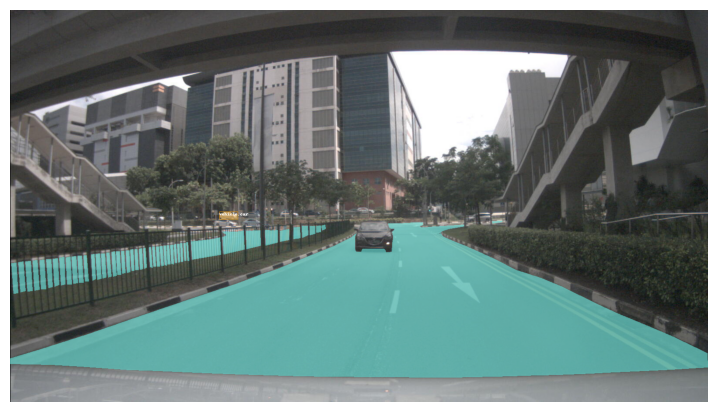

In [10]:
nuim.render_image(key_camera_token, with_category=True, object_tokens=[object_tokens[0]], surface_tokens=[surface_tokens[0]])

To get the raw data (i.e. the segmentation masks, both semantic and instance) of the above, we can use `get_segmentation()`.

In [ ]:
import matplotlib.pyplot as plt

semantic_mask, instance_mask = nuim.get_segmentation(key_camera_token)

plt.figure(figsize=(32, 9))

plt.subplot(1, 2, 1)
plt.imshow(semantic_mask)
plt.subplot(1, 2, 2)
plt.imshow(instance_mask)

plt.show()

Every annotated image (keyframe) comes with up to 6 past and 6 future images, spaced evenly at 500ms +- 250ms.  However, a small percentage of the samples has less sample_datas, either because they were at the beginning or end of a log, or due to delays or dropped data packages.
`list_sample_content()` shows for each sample all the associated sample_datas.

In [ ]:
nuim.list_sample_content(sample['token'])

Besides the annotated images, we can also render the 6 previous and 6 future images, which are not annotated. Let's select the next image, which is taken around 0.5s after the annotated image. We can either manually copy the token from the list above or use the `next` pointer of the `sample_data`.

In [ ]:
next_camera_token = nuim.get('sample_data', key_camera_token)['next']
next_camera_token

Now that we have the next token, let's render it. Note that we cannot render the annotations, as they don't exist.

*Note: If you did not download the non-keyframes (sweeps), this will throw an error! We make sure to catch it here.*

In [ ]:
try:
    nuim.render_image(next_camera_token, annotation_type='none')
except Exception as e:
    print('As expected, we encountered this error:', e)

In this section we have presented a number of rendering functions. For convenience we also provide a script `render_images.py` that runs one or all of these rendering functions on a random subset of the 93k samples in nuImages. To run it, simply execute the following line in your command line. This will save image, depth, pointcloud and trajectory renderings of the front camera to the specified folder.

`>> python nuimages/scripts/render_images.py --mode all --cam_name CAM_FRONT --out_dir ~/Downloads/nuImages --out_type image`

Instead of rendering the annotated keyframe, we can also render a video of the 13 individual images, spaced at 2 Hz.

`>> python nuimages/scripts/render_images.py --mode all --cam_name CAM_FRONT --out_dir ~/Downloads/nuImages --out_type video`

## Poses and CAN bus data

The `ego_pose` provides the translation, rotation, rotation_rate, acceleration and speed measurements closest to each sample_data. We can visualize the trajectories of the ego vehicle throughout the 6s clip of each annotated keyframe. Here the red **x** indicates the start of the trajectory and the green **o** the position at the annotated keyframe.
We can set `rotation_yaw` to have the driving direction at the time of the annotated keyframe point "upwards" in the plot. We can also set `rotation_yaw` to None to use the default orientation (upwards pointing North). To get the raw data of this plot, use `get_ego_pose_data()` or `get_trajectory()`.

In [ ]:
nuim.render_trajectory(sample['token'], rotation_yaw=0, center_key_pose=True)

## Statistics

The `list_*()` methods are useful to get an overview of the dataset dimensions. Note that these statistics are always *for the current split* that we initialized the `NuImages` instance with, rather than the entire dataset.

In [ ]:
nuim.list_logs()

`list_categories()` lists the category frequencies, as well as the category name and description. Each category is either an object or a surface, but not both.

In [12]:
nuim.list_categories(sort_by='object_freq')


Object_anns Surface_anns Name                     Description                                     
      47279            0 vehicle.car              Vehicle designed primarily for personal use, e.g
      28721            0 human.pedestrian.adult   Adult subcategory.                              
      18587            0 movable_object.trafficco All types of traffic cone.                      
      18433            0 movable_object.barrier   Temporary road barrier placed in the scene in or
       6858            0 vehicle.truck            Vehicles primarily designed to haul cargo includ
       3352            0 vehicle.bicycle          Human or electric powered 2-wheeled vehicle desi
       3117            0 human.pedestrian.constru Construction worker                             
       3097            0 vehicle.motorcycle       Gasoline or electric powered 2-wheeled vehicle d
       1823            0 vehicle.bus.rigid        Rigid bus subcategory.                          
       13

We can also specify a `sample_tokens` parameter for `list_categories()` to get the category statistics for a particular set of samples.

In [ ]:
sample_tokens = [nuim.sample[9]['token']]
nuim.list_categories(sample_tokens=sample_tokens)

`list_attributes()` shows the frequency, name and description of all attributes:

In [ ]:
nuim.list_attributes(sort_by='freq')

`list_cameras()` shows us how many camera entries and samples there are for each channel, such as the front camera.
Each camera uses slightly different intrinsic parameters, which will be provided in a future release.

In [ ]:
nuim.list_cameras()

`list_sample_data_histogram()` shows a histogram of the number of images per annotated keyframe. Note that there are at most 13 images per keyframe. For the mini split shown here, all keyframes have 13 images.

In [ ]:
nuim.list_sample_data_histogram()

In [24]:

import pickle
import json

In [26]:
with open('/home/anishmad/msr_thesis/glip/DATASET/nuimages/annotations/nuimages_v1.0-val.json','r') as f:
    dd=json.load(f)

In [32]:
dd['images'][238]

{'id': 238,
 'token': '03f4af2177794d45887ee7b763e7aff7',
 'file_name': 'samples/CAM_BACK_LEFT/n013-2018-09-17-13-09-37+0800__CAM_BACK_LEFT__1537161052897155.jpg',
 'width': 1600,
 'height': 900}

In [30]:
dd['annotations'][2]

{'image_id': 0,
 'category_id': 0,
 'bbox': [778, 446, 45, 28],
 'area': 1260,
 'segmentation': {'counts': 'iS]e08jk02O3L5J3N2M3N2000000000N22NO1O100O100000000000000000000000010000O01O001N2O1AhTOOZk0LnTO0aj^e0',
  'size': [900, 1600]},
 'iscrowd': 0,
 'id': 2}